In [4]:
# import mlflow
# mlflow.set_tracking_uri("http://localhost:5000")
# mlflow.sklearn.autolog()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import taxi_driver.taxi_driver as td

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



# 📋 Evaluation Function
def eval_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<20} | MSE: {mse:.4f} | R²: {r2:.4f}")


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Init Read and cleaning

In [5]:
#setting some much needed paths 

dataPath = os.path.join("./../data")
csvPath  = os.path.join(dataPath,"CSV")
shpPath  = os.path.join(dataPath,"SHP")

outputPath = os.path.join("outputs")
imagePath = os.path.join(outputPath,"images")

clean_df=pd.read_parquet(f'{dataPath}/clean_sample.parquet')


In [7]:
#split the df two to parts 
X=clean_df[["fare_amount",'Airport_flag','trip_distance','congestion_surcharge_flag','mta_tax_flag']]
y=clean_df[["set_tip_amount_flag"]]

# 🪓 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [66]:
from catboost import CatBoostClassifier,CatBoostRegressor


In [92]:
numerical_cols=['fare_amount','trip_distance','extra','tolls_amount']


categorical_cols = ['pu_day',
                    'pu_hour',
                    'Airport_flag',
                    'congestion_surcharge_flag',
                    'is_weekend',
                    'is_night',
                    'mta_tax_flag']

X=clean_df[numerical_cols+categorical_cols]
y=clean_df[["set_tip_amount_flag"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_params = {
    'iterations': 300,
    'learning_rate': 0.1,
    'depth': 4,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'verbose': 50,
    'early_stopping_rounds': 30,
    'random_seed': 42,
    'task_type': 'CPU',
    'one_hot_max_size': 2,
}

# No imputer here
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pass-through numerical features as-is (no imputation)
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

catBoostClassifier = Pipeline([
    ('preprocess', preprocessor),
    ('model', CatBoostClassifier(**cat_params))
])


In [ ]:

catBoostClassifier.fit(X_train, y_train)
y_pred_xgb = catBoostClassifier.predict(X_test)


In [96]:
import optuna

In [99]:

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'random_seed': 42,
        'verbose': 0,
        'early_stopping_rounds': 30,
        'task_type': 'CPU'
    }

    # Fix bootstrap-specific requirements
    if params['bootstrap_type'] != 'Bayesian':
        params.pop('bagging_temperature', None)

    # Create pipeline
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', CatBoostClassifier(**params))
    ])

    # 5-fold CV score (use AUC or accuracy depending on your target)
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy')
    return np.mean(scores)

In [84]:
numerical_cols=['fare_amount','trip_distance','extra','tolls_amount']


categorical_cols = ['pu_day',
                    'pu_hour',
                    'Airport_flag',
                    'congestion_surcharge_flag',
                    'is_weekend',
                    'is_night',
                    'mta_tax_flag',
                    'set_tip_amount_flag'
]

X=clean_df[numerical_cols+categorical_cols]
y=clean_df[["tip_amount"]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)


In [82]:
predicted_set_amount_flag = catBoostClassifier.predict(X_train)


In [83]:
X_train['set_tip_amount_flag']=predicted_set_amount_flag

In [85]:
catBoostRegressor = Pipeline([
    ('preprocess', preprocessor),
    ('model', CatBoostRegressor(**cat_params))
])
catBoostRegressor.fit(X_train, y_train)

0:	learn: 3.6895627	total: 25.7ms	remaining: 7.67s
50:	learn: 1.8884980	total: 1.04s	remaining: 5.09s
100:	learn: 1.8770949	total: 1.99s	remaining: 3.93s
150:	learn: 1.8714620	total: 2.92s	remaining: 2.88s
200:	learn: 1.8673360	total: 3.86s	remaining: 1.9s
250:	learn: 1.8637799	total: 4.8s	remaining: 938ms
299:	learn: 1.8606327	total: 5.69s	remaining: 0us


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['pu_day', 'pu_hour',
                                                   'Airport_flag',
                                                   'congestion_surcharge_flag',
                                                   'is_weekend', 'is_night',
                                                   'mta_tax_flag']),
                                                 ('num', 'passthrough',
                                                  ['fare_amount',
                                                   'trip_distance', 'extra',
                                                   'tolls_amount'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x738dfc7ada60>)])

In [89]:
predicted_set_amount_flag = catBoostClassifier.predict(X_test)
X_test['set_tip_amount_flag']=predicted_set_amount_flag
predicted_tip_amount = catBoostRegressor.predict(X_test)

In [90]:
eval_model('',predicted_tip_amount,y_test)

                     | MSE: 3.5510 | R²: 0.7084


In [49]:
categorical_cols= categorical_cols.append('set_tip_flag')

In [50]:
# Pass-through numerical features as-is (no imputation)
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

In [ ]:
pipeline = Pipeline([
    ('preprocess', preprocessor),  # your ColumnTransformer or similar
    ('catboost_classifier', CatBoostProbaTransformer(CatBoostClassifier(**cat_params))),
    ('regressor', CatBoostRegressor(**cat_params))
])

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.pipeline import Pipeline

class CatBoostProbaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model=None):
        self.model = model or CatBoostClassifier(verbose=0)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def transform(self, X):
        # Return predicted probabilities of the positive class as feature
        return self.model.predict_proba(X)[:, 1].reshape(-1, 1)

In [11]:
from sklearn.metrics import accuracy_score,precision_score,precision_recall_curve,f1_score

In [12]:
accuracy_score(y_pred_xgb,y_test)

0.8185224209175564

In [13]:
precision_score(y_pred_xgb,y_test)

0.9954433068991411

In [36]:
len(X_test['fare_amount']),y_pred_xgb

(339772, array([1, 1, 1, ..., 1, 1, 1], shape=(339772,)))

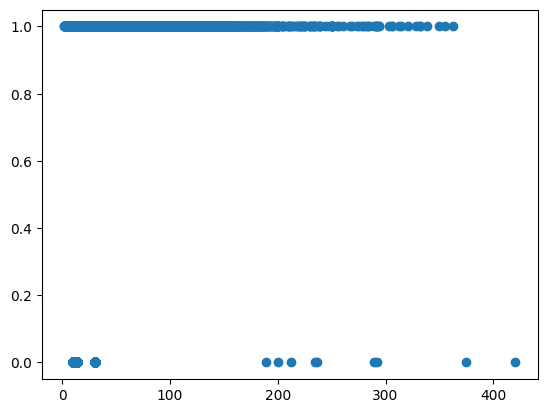

In [41]:
plt.scatter(X_test['fare_amount'],y_pred_xgb)

In [30]:
model = catBoost['model']
model.feature_names_

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44']

In [16]:
from sklearn.metrics import PrecisionRecallDisplay

y_score = catBoost['model'].decision_function(X_test)

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="LinearSVC", plot_chance_level=True, despine=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

AttributeError: 'CatBoostClassifier' object has no attribute 'decision_function'

## RandomForestRegressor

In [10]:
from sklearn.ensemble import RandomForestRegressor
clean_df=pd.read_parquet(f'{dataPath}/clean_sample.parquet')


#split the df two to parts 
X=clean_df[["fare_amount",'Airport_flag','trip_distance','congestion_surcharge_flag','mta_tax_flag']]
y=clean_df[["tip_amount"]]

# 🪓 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='sqrt')
rf.fit(X_train, y_train)
y_pred_rfr = rf.predict(X_test)
eval_model('RFRegressor',y_pred_rfr,y_test)

/media/itoumpalidis/SlowHDD/linux_part/t2l/nyc_taxi_tips/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RFRegressor          | MSE: 3.6061 | R²: 0.6995


we test if including PULocationID and DOLocation in the model increase the performance of the model

In [10]:
indices = np.arange(len(clean_df))

# encode PULocationID and DOLocationID
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
spatial_array = encoder.fit_transform(clean_df[['PULocationID','DOLocationID']])

# 🪓 Train/Test split
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]

y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

In [14]:
x_train = np.concatenate((X_train,spatial_array[train_idx]),axis=1)

rf.fit(x_train, y_train)

x_test = np.concatenate((X_test,spatial_array[test_idx]),axis=1)

y_pred_rfr = rf.predict(x_test)
eval_model('RFRegressor',y_pred_rfr,y_test)

/media/itoumpalidis/SlowHDD/linux_part/t2l/nyc_taxi_tips/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RFRegressor          | MSE: 5.5371 | R²: 0.0428


## HistGradientBoostingRegressor

In [11]:
from sklearn.ensemble import HistGradientBoostingRegressor


In [12]:
clean_df=pd.read_parquet(f'{dataPath}/clean_sample.parquet')


In [13]:
numerical_cols=['fare_amount','trip_distance','duration_s']


categorical_cols = ['RatecodeID', 
                    'store_and_fwd_flag',
                    'PULocationID', 
                    'DOLocationID',
                    'pu_day',
                    'pu_hour',
                    'Airport_flag',
                    'congestion_surcharge_flag',
                    'is_weekend',
                    'is_night',
                    'mta_tax_flag'
]

In [14]:
# No imputer here
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pass-through numerical features as-is (no imputation)
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

In [15]:
X=clean_df[numerical_cols+categorical_cols]
y=clean_df['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
pipe_hist = Pipeline([
    ('preprocess', preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42))
])


In [17]:

pipe_hist.fit(X_train, np.log(y_train))
y_pred_hist = pipe_hist.predict(X_test)

In [18]:
# Evaluation metrics
mae = mean_absolute_error(np.log(y_test), y_pred_hist)
mse = mean_squared_error(np.log(y_test), y_pred_hist)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(y_test), y_pred_hist)

# Print metrics
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


MAE: 0.298
MSE: 0.222
RMSE: 0.471
R²: 0.565


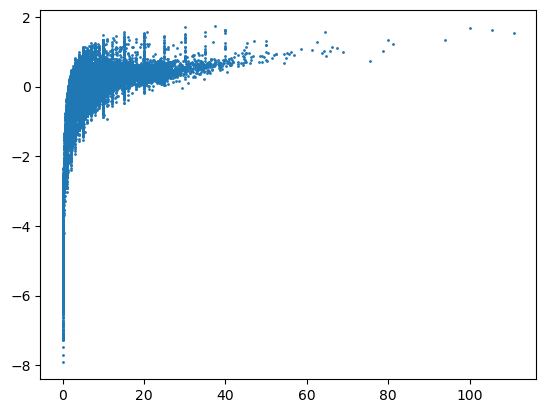

In [19]:
plt.scatter(y_test, np.log(y_test)-y_pred_hist,s=1)

In [31]:
import shap


# 2. Extract the trained preprocessor and regressor
preprocessor = catBoost.named_steps['preprocess']
regressor = catBoost.named_steps['model']

# 3. Transform the input features for SHAP
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# 4. Use SHAP TreeExplainer on the final estimator
explainer = shap.Explainer(regressor, X_train_transformed[0:1000])


In [32]:
shap_values = explainer(X_test_transformed,check_additivity=False)


100%|===================| 339494/339772 [08:45<00:00]        

In [36]:
ohe = preprocessor.named_transformers_['cat'].named_steps['encoder']
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)

feature_names = list(encoded_cat_cols) + numerical_cols


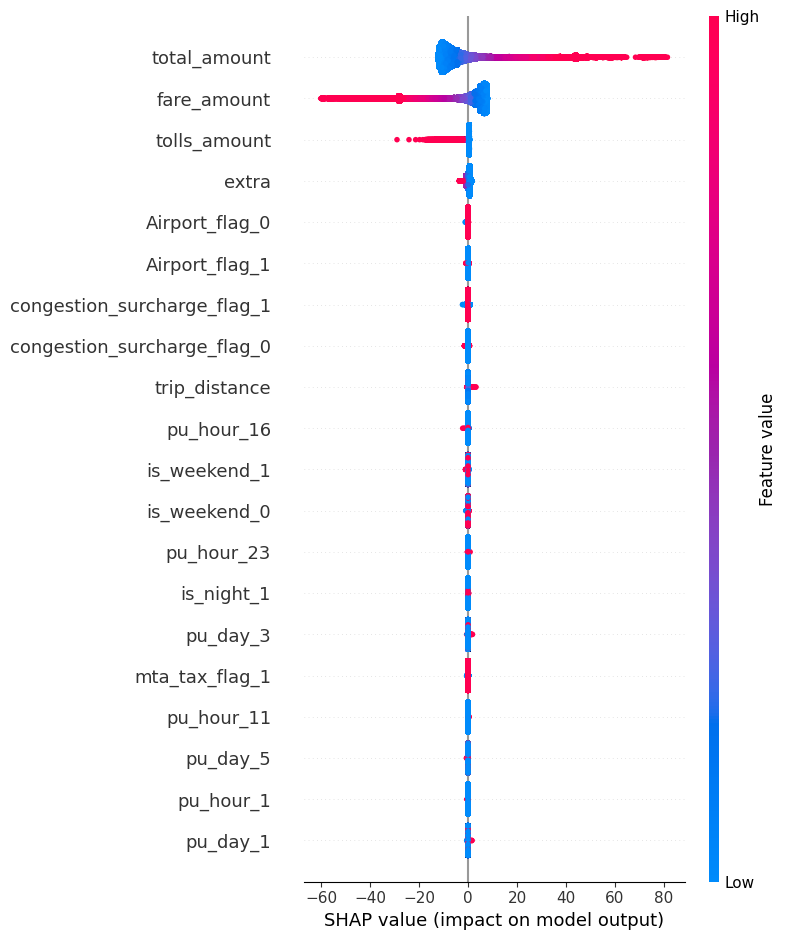

In [37]:

# 5. Visualize
shap.summary_plot(shap_values, X_test_transformed,feature_names=feature_names)

## XGBOOST

In [32]:
from xgboost import XGBRegressor

pipe_xgb = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        tree_method='hist'
    ))
])

pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_test)

In [33]:
# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

# Print metrics
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


MAE: 0.998
MSE: 3.233
RMSE: 1.798
R²: 0.766


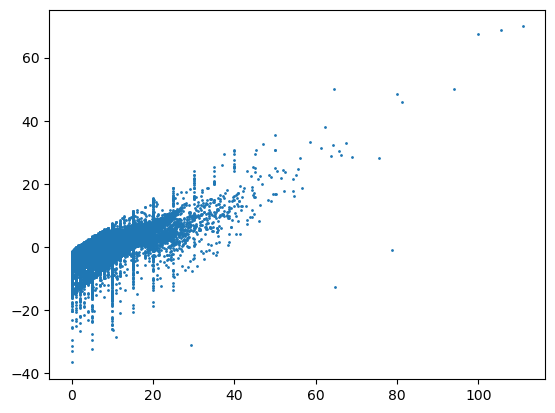

In [34]:
plt.scatter(y_test, y_test-y_pred_xgb,s=1)

## CatBoost

In [ ]:
from catboost import CatBoostRegressor
clean_df=pd.read_parquet(f'{dataPath}/clean_sample.parquet')

In [ ]:
numerical_cols=['fare_amount','trip_distance','extra','tolls_amount']


categorical_cols = ['pu_day',
                    'pu_hour',
                    'Airport_flag',
                    'congestion_surcharge_flag',
                    'is_weekend',
                    'is_night',
                    'mta_tax_flag'
]

In [11]:

X=clean_df[numerical_cols+categorical_cols]
y=clean_df['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
# cat_params = {
#     'n_estimators': 100,
#     'learning_rate': 0.10899577626375372,
#     'depth': 7,
#     'colsample_bylevel': 0.7340962061535496,
#     'random_strength': 6.262882561405091,
#     'min_data_in_leaf': 92,
#     'verbose': 0
# } 

cat_params = {
    'iterations': 300,
    'learning_rate': 0.1,
    'depth': 4,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'verbose': 50,
    'early_stopping_rounds': 30,
    'random_seed': 42,
    'task_type': 'CPU',
    'one_hot_max_size': 2,
}

# No imputer here
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pass-through numerical features as-is (no imputation)
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

catBoost = Pipeline([
    ('preprocess', preprocessor),
    ('model', CatBoostRegressor(**cat_params))
])

catBoost.fit(X_train, y_train)
y_pred_xgb = catBoost.predict(X_test)


# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

# Print metrics
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


2025/06/02 15:29:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1336d335e4674bbe919ec83be034cb84', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/06/02 15:29:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling 

0:	learn: 3.6599797	total: 23.3ms	remaining: 6.97s
50:	learn: 1.4534304	total: 1.21s	remaining: 5.91s
100:	learn: 1.3097278	total: 2.36s	remaining: 4.66s
150:	learn: 1.2058839	total: 3.52s	remaining: 3.47s
200:	learn: 1.1272601	total: 4.71s	remaining: 2.32s
250:	learn: 1.0671912	total: 5.82s	remaining: 1.14s
299:	learn: 1.0126136	total: 6.95s	remaining: 0us


2025/06/02 15:30:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:30:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to cond

🏃 View run selective-carp-682 at: http://localhost:5000/#/experiments/0/runs/1336d335e4674bbe919ec83be034cb84
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:30:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


MAE: 0.474
MSE: 1.051
RMSE: 1.025
R²: 0.933


In [14]:
from joblib import dump, load

dump(catBoost, 'data/models/pipeline_model.joblib')


['data/models/pipeline_model.joblib']

In [ ]:
pipeline = load('pipeline_model.joblib')


In [25]:
model = catBoost['model']

# Get feature importance
feature_importance = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Create a DataFrame to view the feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

print(feature_importance_df.sort_values(by='Importance', ascending=False))

ValueError: All arrays must be of the same length